<h1 style="text-align: center;">Capstone Project 3: Reviews Analysis Using NLP</h1>



# Table of contents
* [1.0 Introduction](#1.0_Introduction)
* [2.0 Data Wrangling](#2.0_Data_Wrangling)
* [3.0 Explorartory Data Analysis](#3.0_Explorartory_Data_Analysis)
* [4.0 Pre-processing and Training Data Development](#4.0_Pre-processing_and_Training_Data_Development)
* [5.0 Training and Testing](#5.0_Training_and_Testing)
* [6.0 Modelling](#6.0_Modelling)
* [7.0 Next Steps](#7.0_Next_Steps)

# 1.0 Introduction <a id="1.0_Introduction"></a>

## 1.1 Problem Statement 
What opportunities exist to predict the condition score of equipment through analyzing reviews, which may save a ton of time for data entry of the project?

## 1.2 Context
I’m currenlty responsible for organizing and manipulating data, which will be generating results for the clients who want to know the condition rating of  their assets. However, the most time consuming part would be interpreting the meaning of the inspector's comments about the condition of these assets. Currently, we collected over 3000 condition assessment reviews on different equipment in different categories. I’m hoping to use the ML NLP techniques to predict the condition rating and analyze the sentiment of their review.

## 1.3 Criteria for Success
Above 85% accuracy of predicting the condition scores would be considered as a successful model and good tool to be used in projects

## 1.4 Scope of Solution Space
Asset condition review data will be used to predict the condition rating.

## 1.5 Constraints
There might be an data imbalance issue, as most of assets have condition score 2-4, and few are 1-5




# 2.0 Data Wrangling <a id="2.0_Data_Wrangling"></a>

## 2.1 Preview of Data

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import __version__ as sklearn_version

In [2]:
#Load Comments Data
comments = pd.read_excel('../data/raw/ConditionAssessmentCommentsData.xlsx')

#Preview Data
comments.head()

,Discipline,OverallConditionrating1_5,InspectorsComments,Keyword
0,Process Electrical,2.0,"Fixtures were in good condition, however they ...",An electrical connection for a portable gener...
1,Building and Process Structural,3.0,The concrete foundation could not be inspected...,NaN
2,Building and Process Structural,3.0,The steel tank was observed to be in fair cond...,Corrosion
3,Building Services,5.0,Exhaust Fan 1 was missing.,missing
4,Process Mechanical Equipment,3.0,Sewage Lift Pump 1 was in fair condition with ...,moderate surface corrosion


In [3]:
#Check if there are any null values
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Discipline                 2295 non-null   object 
 1   OverallConditionrating1_5  2289 non-null   float64
 2   InspectorsComments         2251 non-null   object 
 3   Keyword                    889 non-null    object 
dtypes: float64(1), object(3)
memory usage: 74.8+ KB


In [4]:
#Check destribution
comments.describe()

,OverallConditionrating1_5
count,2289.000000
mean,2.445609
std,0.599198
min,2.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,5.000000


(array([1376.,    0.,    0.,  827.,    0.,    0.,   65.,    0.,    0.,
          21.]),
 array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
 <BarContainer object of 10 artists>)

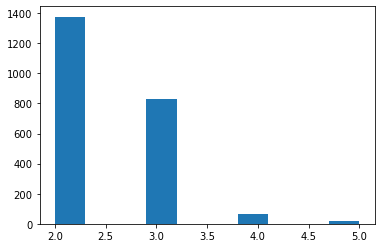

In [5]:
#Use Histogram to check the distribution
plt.hist(comments.OverallConditionrating1_5)

In [6]:
#Count the number of rating
comments.OverallConditionrating1_5.value_counts().sort_values(ascending=False)

2.0    1376
3.0     827
4.0      65
5.0      21
Name: OverallConditionrating1_5, dtype: int64

As we can see, we don't have any rated 1 comments. Also, the very good asset only have 21 assets. These minor assets may lead to serious imbalance. There are a few ways usually to remove the imbalance, including 

1) Collect More Data (Possible)

2) Resample the imbalanced data to make the imbalanced data balacned (if collecting more data is not feasible)

3) Use performance evaluation metrics, specially for imbalanced data (if previous approaches not available)

4) Cross-Validation (can definetely use this!)

5) Use Boosting approaches (can definetely try this!)

Reference: https://medium.com/@itbodhi/handling-imbalanced-data-sets-in-machine-learning-5e5f33c70163


After checking our previous databases, I do find more data that can be used to increase the number of rating 4 and 5. Import additional data and explore this data.

In [7]:
#Load Comments Data
add_comments = pd.read_excel('../data/raw/Additional Comments.xlsx')

#Preview Data
add_comments.head()

,Condition Rating,Comments,Category
0,2,This asset was observed in Good Condition. Ver...,PPE
1,3,This asset was assumed in fair condition. Corr...,PPE
2,3,This asset was observed in Fair Condition. Cor...,PPE
3,5,This asset was observed in Poor Condition. Min...,PPE
4,5,This asset was observed in Poor Condition. Min...,PPE


In [8]:
#Count the number of rating
add_comments['Condition Rating'].value_counts().sort_values(ascending=False)

2    723
3    364
5     34
4     31
Name: Condition Rating, dtype: int64

In [9]:
#Although there are not many 4 and 5 data, but still, we can add them in the current database.
add_comments_45 = add_comments[(add_comments['Condition Rating'] == 4) | (add_comments['Condition Rating'] == 5)]
add_comments_45.head()

,Condition Rating,Comments,Category
3,5,This asset was observed in Poor Condition. Min...,PPE
4,5,This asset was observed in Poor Condition. Min...,PPE
50,5,This asset was observed in Poor Condition. Cor...,PPE
51,5,This asset was observed in Poor Condition. Min...,PPE
81,5,This asset was observed in Poor Condition. The...,PPE


In [10]:
#Rename the columns to be consistent with the Comments dataframe
Columns = {'Condition Rating':'OverallConditionrating1_5', 'Comments':'InspectorsComments', 'Category':'Discipline'}
add_comments_45.rename(columns = Columns, inplace = True)
add_comments_45.head()

/Users/andygong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,OverallConditionrating1_5,InspectorsComments,Discipline
3,5,This asset was observed in Poor Condition. Min...,PPE
4,5,This asset was observed in Poor Condition. Min...,PPE
50,5,This asset was observed in Poor Condition. Cor...,PPE
51,5,This asset was observed in Poor Condition. Min...,PPE
81,5,This asset was observed in Poor Condition. The...,PPE


In [11]:
#Drop the unnecessary column
comments=comments.drop(columns='Keyword').dropna(axis=0, how='any')

In [12]:
#Append the add_comments45
comments_add = comments.append(add_comments_45, ignore_index=True)
comments_add.head()

,Discipline,OverallConditionrating1_5,InspectorsComments
0,Process Electrical,2.0,"Fixtures were in good condition, however they ..."
1,Building and Process Structural,3.0,The concrete foundation could not be inspected...
2,Building and Process Structural,3.0,The steel tank was observed to be in fair cond...
3,Building Services,5.0,Exhaust Fan 1 was missing.
4,Process Mechanical Equipment,3.0,Sewage Lift Pump 1 was in fair condition with ...


In [13]:
comments_add.OverallConditionrating1_5.value_counts().sort_values(ascending=False)

2.0    1332
3.0     827
4.0      96
5.0      55
Name: OverallConditionrating1_5, dtype: int64

In [14]:
comments = comments_add

## 2.2 Data Cleaning

### 2.2.1 Cleaning Discipline Data

The first thing to be cleaned is the Discipline. Utimately, we wanted to use the different categorical data to be a useful classification feature, as different categories may have impact of the rating.

In [15]:
#Explore the discipline data
comments.Discipline.value_counts()

Building and Process Structural    460
Process Mechanical Equipment       370
Process Electrical                 208
Building Services                  171
Building Architectural             153
Process Instrumentation SCADA      135
Process Piping                     119
SC                                 114
PM                                 114
Process Mechanical                  74
AC                                  54
SW                                  45
BM                                  40
Building Mechanical                 39
Architectural                       38
PPE                                 37
Structural                          35
ES                                  24
BA                                  22
Building Mechanical                 14
Process Mechanical                  10
HSS                                 10
Instrumentation and Control          7
Electrical                           7
SIC                                  6
PE                       

In [16]:
comments.Discipline = comments.Discipline.replace({
    'Building and Process Structural' : 'SC',
    'Process Mechanical Equipment' : 'PM',
    'Process Electrical' : 'ES',
    'Building Services' : 'ES',
    'Building Architectural': 'AC',
    'Process Piping': 'PM',
    'Process Mechanical': 'PM',
    'Building Mechanical': 'BM',
    'Architectural': 'AC',
    'Structural': 'SC',
    'Instrumentation and Control': 'SC',
    'Electrical': 'ES',
    'Process Instrumentation SCADA':'SIC',
    'Process Mechanical ':'PM',
    'Building Mechanical ': 'BM',
    'Instrumentation and Control ': 'SIC',
    'PPE':'PM',
    'BA':'AC',
    'BS':'SC',
    'PE':'ES'})
comments.Discipline.value_counts()

PM                             650
SC                             610
ES                             413
AC                             267
SIC                            141
Process Mechanical              74
BM                              54
SW                              45
Building Mechanical             39
HSS                             10
Instrumentation and Control      7
Name: Discipline, dtype: int64

In [17]:
comments.loc[comments.Discipline.str.contains('Process'), 'Discipline'] = 'PM'
comments.loc[comments.Discipline.str.contains('Building'), 'Discipline'] = 'BM'
comments.loc[comments.Discipline.str.contains('Instrumentation'), 'Discipline'] = 'SIC'

In [18]:
comments.Discipline.value_counts()

PM     724
SC     610
ES     413
AC     267
SIC    148
BM      93
SW      45
HSS     10
Name: Discipline, dtype: int64

### 2.2.2 Clean Condition Rating

In [19]:
# Convert the condition rating from Float to Int
comments['Insp'] = comments['OverallConditionrating1_5'].astype(int)
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Discipline                 2310 non-null   object 
 1   OverallConditionrating1_5  2310 non-null   float64
 2   InspectorsComments         2310 non-null   object 
 3   Insp                       2310 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 72.3+ KB


### 2.2.3 Clean Inspector's Comments Data

In [20]:
for index,text in enumerate(comments['InspectorsComments'][35:40]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 Sewage Lift Pump 2 Discharge Check Valve was in fair condition. Severe surface corrosion was observed.
Review 2:
 Sewage Lift Pump 2 was in fair condition. Corrosion was observed on the visible parts of the pump. No performance issues were reported , however the pump was approaching the end of its remaining service life.
Review 3:
 The concrete roof was observed to be in fair condition. Minor wear with exposed aggregates was noted on the underside.
Review 4:
 Aluminum ladder was observed to be in fair condition. Anchor bolts, washers and nuts were noted to be corroded. Deposits were noted throughout.
Review 5:
 Main Breaker was in good condition.


For the text data, we may want clean a few things before moving to the EDA step:

1) Lower case all words

2) Remove any punctuations

3) Remove stop words

4) Lemmatization to make words to its base form (e.g. 'moving' can be lemmatized to 'move')

In [21]:
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math

In [22]:
#Lowercase the Insepctor's Comments
comments['processing']=comments['InspectorsComments'].apply(lambda x: x.lower())
comments['processing'].head()

0    fixtures were in good condition, however they ...
1    the concrete foundation could not be inspected...
2    the steel tank was observed to be in fair cond...
3                           exhaust fan 1 was missing.
4    sewage lift pump 1 was in fair condition with ...
Name: processing, dtype: object

In [23]:
#Remove any punctuations
comments['processing']=comments['processing'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [24]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Discipline                 2310 non-null   object 
 1   OverallConditionrating1_5  2310 non-null   float64
 2   InspectorsComments         2310 non-null   object 
 3   Insp                       2310 non-null   int64  
 4   processing                 2310 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 90.4+ KB


In [25]:
#Remove stop words and lemmatization the words
# Importing spacy
import spacy
# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
# Lemmatization with stopwords removal
comments['lemmatized']=comments['processing'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [26]:
comments.head()

,Discipline,OverallConditionrating1_5,InspectorsComments,Insp,processing,lemmatized
0,ES,2.0,"Fixtures were in good condition, however they ...",2,fixtures were in good condition however they d...,fixture good condition mechanical protection
1,SC,3.0,The concrete foundation could not be inspected...,3,the concrete foundation could not be inspected...,concrete foundation inspect bury foundation as...
2,SC,3.0,The steel tank was observed to be in fair cond...,3,the steel tank was observed to be in fair cond...,steel tank observe fair condition corrosion no...
3,ES,5.0,Exhaust Fan 1 was missing.,5,exhaust fan 1 was missing,exhaust fan 1 miss
4,PM,3.0,Sewage Lift Pump 1 was in fair condition with ...,3,sewage lift pump 1 was in fair condition with ...,sewage lift pump 1 fair condition moderate sur...


The data has been cleaned completely.

# 3.0 Explorartory Data Analysis <a id="3.0_Explorartory_Data_Analysis"></a>

## 3.1 Discipline

Distribution of disciplines of review can be explored by ploting the histogram and label each bar

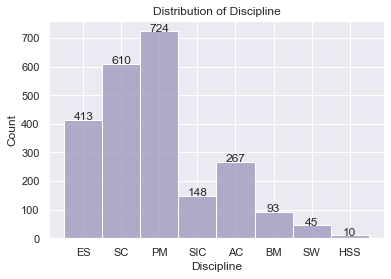

In [27]:
#Set theme of Seaborn
sns.set_theme()
# plot histogram 
ax = sns.histplot(data=comments, x="Discipline", color='#9d94ba')
ax.set(title='Distribution of Discipline')
# label each bar in histogram
for p in ax.patches:
    height = p.get_height() # get the height of each bar
    # adding text to each bar
    ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
            y = height+0.2, # y-coordinate position of data label, padded 0.2 above bar
    s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
    ha = 'center') # sets horizontal alignment (ha) to center

PM has the most assets, while HSS has the least assets.

[Text(0.5, 1.0, 'Distribution of Discipline, with Condition Rating')]

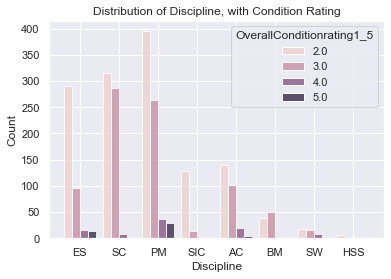

In [28]:
#Present the histogram with rating
ax = sns.histplot(data=comments, x="Discipline", color='#9d94ba', hue='OverallConditionrating1_5', 
                  multiple="dodge",shrink=.8)
ax.set(title='Distribution of Discipline, with Condition Rating')

## 3.2 Condition Rating

Distribution of condition rating of review can be explored by ploting the histogram and label each bar

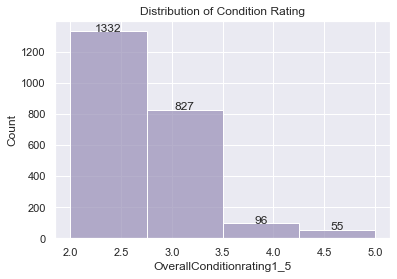

In [29]:
#Set theme of Seaborn
sns.set_theme()
# plot histogram 
ax = sns.histplot(data=comments, x="OverallConditionrating1_5", color='#9d94ba', bins=4)
ax.set(title='Distribution of Condition Rating')
# label each bar in histogram
for p in ax.patches:
    height = p.get_height() # get the height of each bar
    # adding text to each bar
    ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
            y = height+0.2, # y-coordinate position of data label, padded 0.2 above bar
    s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
    ha = 'center') # sets horizontal alignment (ha) to center

## 3.3 Word Cloud

### 3.3.1 Word Cloud by Discipline

In [30]:
comments_grouped=comments[['Discipline','lemmatized']].groupby(by='Discipline').agg(lambda x:' '.join(x))
comments_grouped.head()

,lemmatized
Discipline,
AC,metal roof observe fair condition section roof...
BM,moderate surface corrosion observe moderate su...
ES,fixture good condition mechanical protection e...
HSS,minor surface corrosion eye wash station obser...
PM,sewage lift pump 1 fair condition moderate sur...


In [31]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
c_vec=CountVectorizer(analyzer='word')
data=c_vec.fit_transform(comments_grouped['lemmatized'])
com_dtm = pd.DataFrame(data.toarray(), columns=c_vec.get_feature_names())
com_dtm.index=comments_grouped.index
com_dtm.head(3).T

/Users/andygong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Discipline,AC,BM,ES
00002251,0,0,0
00042968,0,0,0
00044244,0,0,0
00079718,0,0,0
06,0,0,0
...,...,...,...
workingatmospheric,0,0,0
wrap,0,0,0
wrong,0,0,0
year,0,0,2


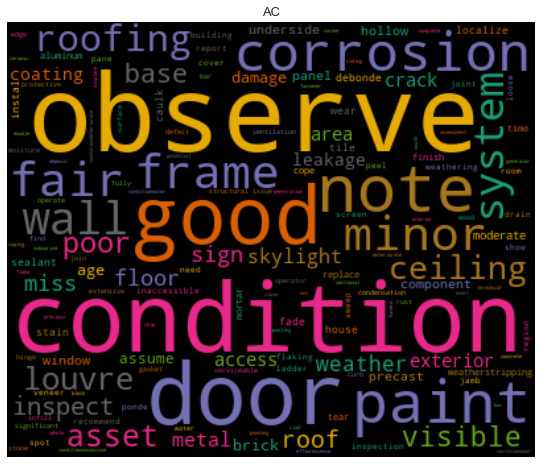

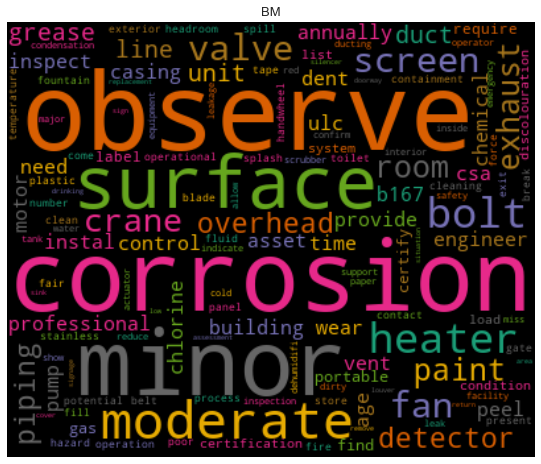

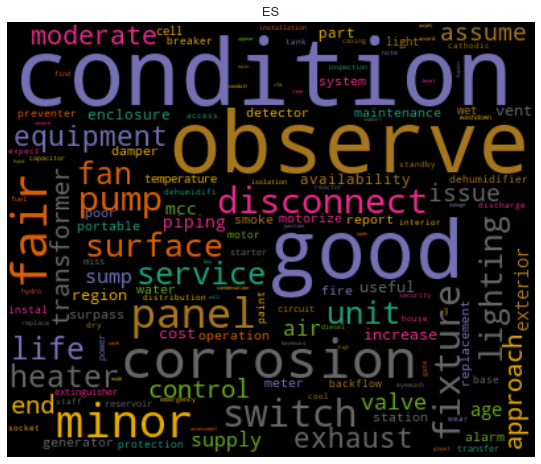

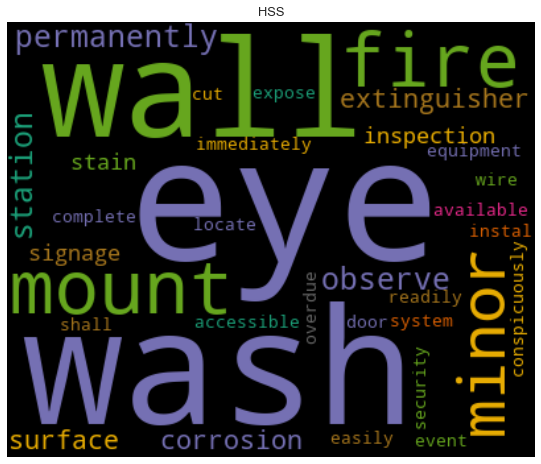

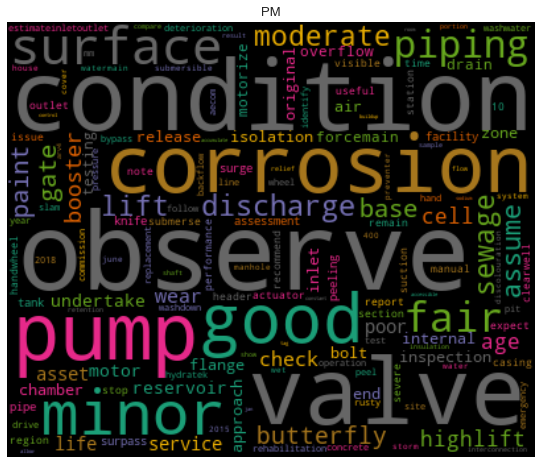

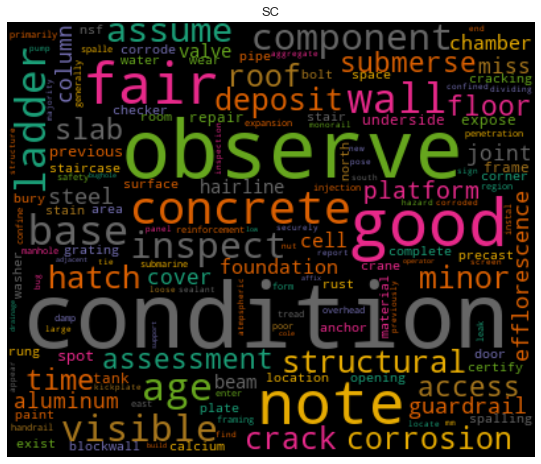

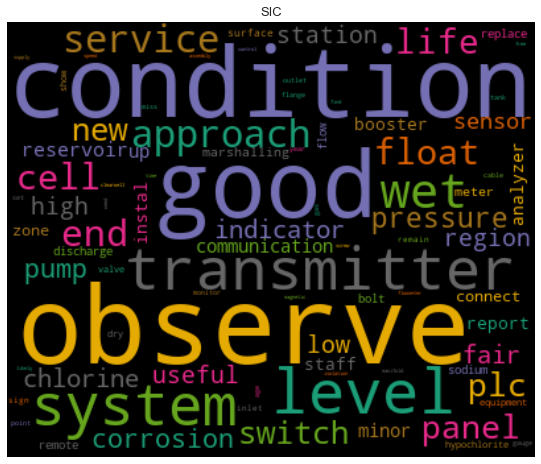

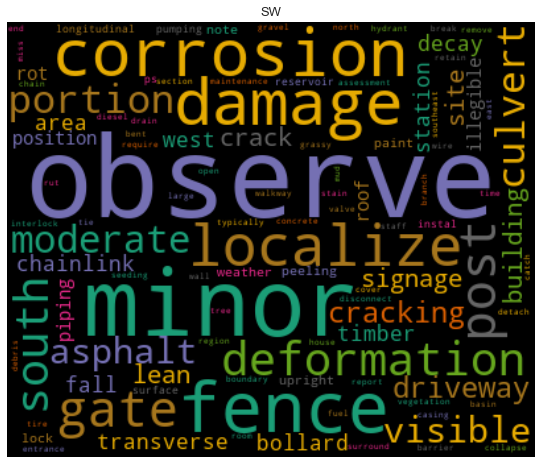

In [32]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap
# Function for generating word clouds
def generate_wordcloud(data,title):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()
# Transposing document term matrix
com_dtm=com_dtm.transpose()
# Plotting word cloud for each product
for index,dis in enumerate(com_dtm.columns):
    generate_wordcloud(com_dtm[dis].sort_values(ascending=False),dis)

"Condition" is absolutely a high-frequent word for all disciplines, but doesn't have any meaning.

"Good" is a also high-frequent word but not appear in every discipline.

### 3.3.2 Word Cloud by Condition Rating

In [33]:
r_comments=comments[['OverallConditionrating1_5','lemmatized']]
r_comments['OverallConditionrating1_5']=r_comments['OverallConditionrating1_5'].astype(str)
r_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   OverallConditionrating1_5  2310 non-null   object
 1   lemmatized                 2310 non-null   object
dtypes: object(2)
memory usage: 36.2+ KB


/var/folders/sc/zm445gtj461388gkngwypfbw0000gn/T/ipykernel_66151/1737639808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_comments['OverallConditionrating1_5']=r_comments['OverallConditionrating1_5'].astype(str)


In [34]:
r_comments_grouped=r_comments.groupby(by='OverallConditionrating1_5').agg(lambda x:' '.join(x))
r_comments_grouped.head()

,lemmatized
OverallConditionrating1_5,
2.0,fixture good condition mechanical protection m...
3.0,concrete foundation inspect bury foundation as...
4.0,roof observe poor condition corrode expose reb...
5.0,exhaust fan 1 miss forcemain poor condition re...


/Users/andygong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


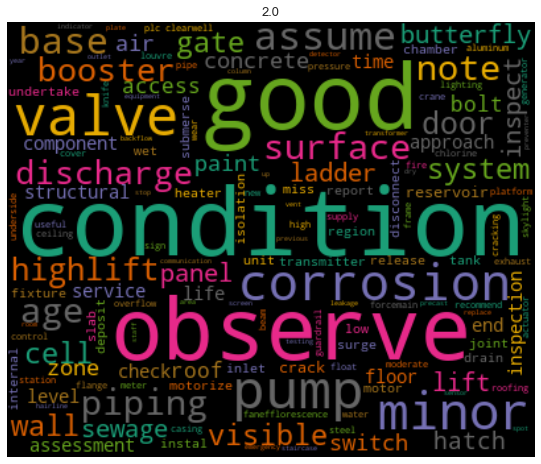

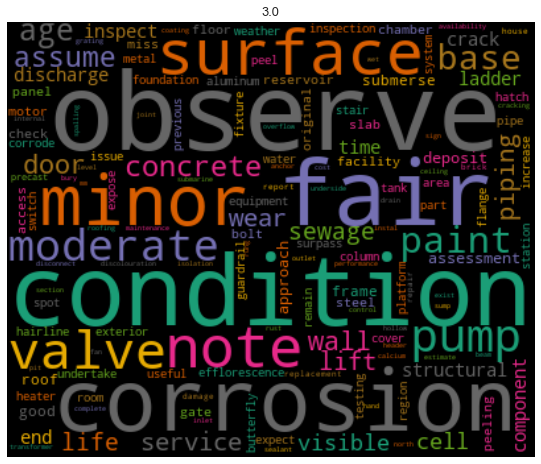

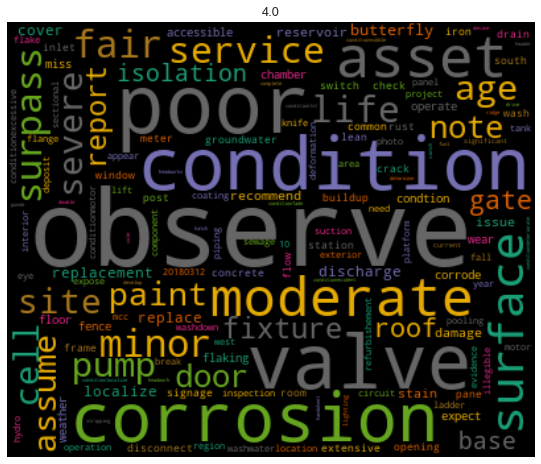

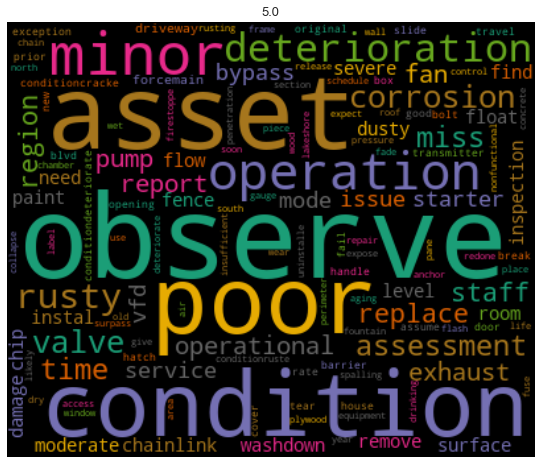

In [35]:
c_vec=CountVectorizer(analyzer='word')
data=c_vec.fit_transform(r_comments_grouped['lemmatized'])
c_com_dtm = pd.DataFrame(data.toarray(), columns=c_vec.get_feature_names())
c_com_dtm.index=r_comments_grouped.index

# Transposing document term matrix
c_com_dtm=c_com_dtm.transpose()
# Plotting word cloud for each product
for index,condition in enumerate(c_com_dtm.columns):
    generate_wordcloud(c_com_dtm[condition].sort_values(ascending=False),condition)

"Observe" and "condition" is a very high frequent word in any rating.

The word "Good", "Fair", "Poor" have very strong meaning of the conditions.

# 4.0 Pre-processing and Training Data Development <a id="4.0_Pre-processing_and_Training_Data_Development"></a>

In [36]:
#Check the data again
comments.head()

,Discipline,OverallConditionrating1_5,InspectorsComments,Insp,processing,lemmatized
0,ES,2.0,"Fixtures were in good condition, however they ...",2,fixtures were in good condition however they d...,fixture good condition mechanical protection
1,SC,3.0,The concrete foundation could not be inspected...,3,the concrete foundation could not be inspected...,concrete foundation inspect bury foundation as...
2,SC,3.0,The steel tank was observed to be in fair cond...,3,the steel tank was observed to be in fair cond...,steel tank observe fair condition corrosion no...
3,ES,5.0,Exhaust Fan 1 was missing.,5,exhaust fan 1 was missing,exhaust fan 1 miss
4,PM,3.0,Sewage Lift Pump 1 was in fair condition with ...,3,sewage lift pump 1 was in fair condition with ...,sewage lift pump 1 fair condition moderate sur...


The first step would be to split the train and test data using Train Test Split function. This can split a set of test data to verify the model's accuracy. The test set won't be used for anything else

In [40]:
#Get the features and the targets
X = comments[['lemmatized', 'Discipline']]
y = comments['Insp']
print(X.shape, y.shape)

(2310, 2) (2310,)


In [42]:
#Test train split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)
#Check the shape of each set
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1848, 2) (462, 2) (1848,) (462,)


In this training dataset, we not only have the text data, but also have the Discipline data, which is a categorical data, used for categorize each Discipline. We believe that the category has some sorts of relationship between the comments and the condition rating. So we will keep it as a categorical data. However, the model only recognize numerical data. We can use the OrdinalEncoder from Sci-kit Learn to encode these categorical data. Also, to deal with the text vectorization at the same time, the Sci-kit Learn requires an extra step to transform both columns at the same time and then concat together. 

In [100]:
#Initialize the encoder
encoder = OneHotEncoder()

In [101]:
#Initialize the count vectorizer and remove the stop words at the same time
vec = CountVectorizer(stop_words = 'english', analyzer='word')

In [102]:
#Initialize the preprocessor by using the ColumnTransformer
preprocessor = ColumnTransformer(transformers = [
                                    ('cat', encoder, ['Discipline']),
                                      ('text', vec, 'lemmatized')
                                    ])

# 5.0 Training and Testing <a id="5.0_Training_and_Testing"></a>

## 5.1 Logistic Regression Model

In [103]:
#Create a pipeline that includes the column transformer and the model
lr_pipe = Pipeline([('preprocessor', preprocessor),
                 ('lr', LogisticRegression(max_iter=10000))])

In [104]:
#fit the model and make predictions to y_pred_lr
lr_pipe.fit(X_train, y_train)

y_pred_lr = lr_pipe.predict(X_test)

y_pred_lr_train = lr_pipe.predict(X_train)

In [105]:
#Show the overall accuracy
print("The accuracy for predicting training sets is ", metrics.accuracy_score(y_train, y_pred_lr_train))
print("The accuracy for predicting test sets is ", metrics.accuracy_score(y_test, y_pred_lr))

The accuracy for predicting training sets is  0.9588744588744589
The accuracy for predicting test sets is  0.8831168831168831


As a result, the logistic regression model was doing okay for the datasets. The overall accuracy for the training set is 96% and 87% for test set. The model has a bit overfitting on training data, which caused less accuracy for test set.

Let's explore more by ploting the confusion matrix:

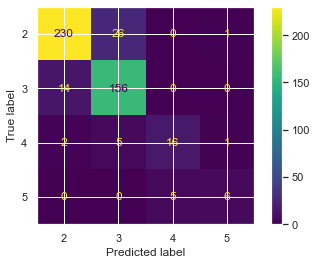

In [106]:
test_confusion = metrics.confusion_matrix(y_test, y_pred_lr)
cmd = ConfusionMatrixDisplay(test_confusion, display_labels=[2,3,4,5])
cmd.plot()

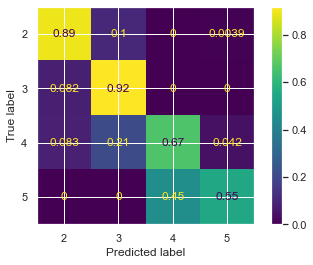

In [107]:
#Normalize the results by showing the percentage of predcited labels
test_confusion = metrics.confusion_matrix(y_test, y_pred_lr, normalize='true')
cmd = ConfusionMatrixDisplay(test_confusion, display_labels=[2,3,4,5])
cmd.plot()

Predicting for Rating 2 and 3 are pretty good. However, the 4 and 5 are less accurate, especially for the 5. The mdoel can be falsely predict label to 4 but actaully 5 with 45% of the chance.

Results can also be seen in the classification report below.

In [108]:
print(metrics.classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           2       0.93      0.89      0.91       257
           3       0.83      0.92      0.87       170
           4       0.76      0.67      0.71        24
           5       0.75      0.55      0.63        11

    accuracy                           0.88       462
   macro avg       0.82      0.76      0.78       462
weighted avg       0.88      0.88      0.88       462



Low recall for Rating 4 and 5, indicating that the model can hardly detect reviews with rating 4 and 5. However, higher precision for rating 4 means if the model detects a rating 4 review, it has 75% of the chance it is correct, which is relatively okay.

One of the reason for low 4 and 5 accuracy is the low number of data. 

## 5.2 Random Forest Model

In [109]:
#Start with creating a pipe
rf_pipe = Pipeline([('preprocessor', preprocessor),
                 ('rf', RandomForestClassifier())])
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Discipline']),
                                                 ('text',
                                                  CountVectorizer(stop_words='english'),
                                                  'lemmatized')])),
                ('rf', RandomForestClassifier())])

In [110]:
#Make Predictions
y_pred_rf = rf_pipe.predict(X_test)

y_pred_rf_train = rf_pipe.predict(X_train)

In [111]:
#Show the overall accuracy
print("The accuracy for predicting training sets is ", metrics.accuracy_score(y_train, y_pred_rf_train))
print("The accuracy for predicting test sets is ", metrics.accuracy_score(y_test, y_pred_rf))

The accuracy for predicting training sets is  0.9794372294372294
The accuracy for predicting test sets is  0.8852813852813853


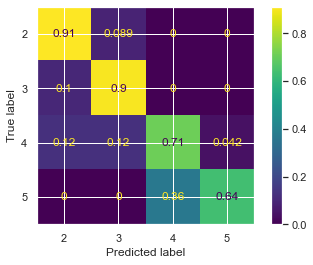

In [70]:
#Normalize the results by showing the percentage of predcited labels
test_confusion = metrics.confusion_matrix(y_test, y_pred_rf, normalize='true')
cmd = ConfusionMatrixDisplay(test_confusion, display_labels=[2,3,4,5])
cmd.plot()

The randomforest model seems to work better on the Rating 2, 4, and 5, compared to the logistic regression model.

In [71]:
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           2       0.92      0.91      0.92       257
           3       0.85      0.90      0.88       170
           4       0.81      0.71      0.76        24
           5       0.88      0.64      0.74        11

    accuracy                           0.89       462
   macro avg       0.87      0.79      0.82       462
weighted avg       0.89      0.89      0.89       462



Explore the feature importance to see if we can regularization of the model to fix the overfitting issue

### 5.2.1 Feature Importance and Selection

In [112]:
#Extract category from the pipeline
preprocessor_model = rf_pipe.named_steps['preprocessor']

In [117]:
labels = preprocessor_model.get_feature_names_out()
print(labels)

['cat__Discipline_AC' 'cat__Discipline_BM' 'cat__Discipline_ES' ...
 'text__wrong' 'text__year' 'text__zone']


In [119]:
transformed_df_columns = pd.DataFrame(preprocessor_model.transform(X_train).toarray(), columns=labels).columns
print(transformed_df_columns)

Index(['cat__Discipline_AC', 'cat__Discipline_BM', 'cat__Discipline_ES',
       'cat__Discipline_HSS', 'cat__Discipline_PM', 'cat__Discipline_SC',
       'cat__Discipline_SIC', 'cat__Discipline_SW', 'text__00002251',
       'text__00042968',
       ...
       'text__window', 'text__winter', 'text__wire', 'text__wit', 'text__wood',
       'text__work', 'text__workingatmospheric', 'text__wrong', 'text__year',
       'text__zone'],
      dtype='object', length=1086)


In [127]:
#Get the feature importance of each feature
rf_model = rf_pipe.named_steps['rf']

feature_scores = pd.DataFrame(rf_model.feature_importances_, index=labels, columns=['Feature_Importance'])

feature_scores

,Feature_Importance
cat__Discipline_AC,0.004336
cat__Discipline_BM,0.004967
cat__Discipline_ES,0.007789
cat__Discipline_HSS,0.001524
cat__Discipline_PM,0.005940
...,...
text__work,0.000060
text__workingatmospheric,0.000109
text__wrong,0.000036
text__year,0.000407


In [130]:
#Print to see the most important features and their feature importance coefficient
feature_scores.sort_values(by='Feature_Importance',ascending=False).head(20)

,Feature_Importance
text__good,0.164437
text__fair,0.131744
text__condition,0.040260
text__corrosion,0.035456
text__moderate,0.027889
text__poor,0.024507
text__note,0.021667
text__observe,0.020044
text__asset,0.017921
text__minor,0.017877


In [184]:
#The above feature is that imformative
#Let's see the distribution of the importance features
print(feature_scores.describe())
a = feature_scores.describe().iloc[6,0]

       Feature_Importance
count         1086.000000
mean             0.000921
std              0.006838
min              0.000000
25%              0.000026
50%              0.000126
75%              0.000432
max              0.164437


In [185]:
#Can we select half of the features and check to see if the model is doing better without these features?
half_features = list(feature_scores[feature_scores['Feature_Importance']<=a].index)

In [193]:
#Fit and Tranform the X_train data
pre = preprocessor.fit(X_train)

In [194]:
X_train_cut = pre.transform(X_train)
X_train_cut

<1848x1086 sparse matrix of type '<class 'numpy.float64'>'
	with 16542 stored elements in Compressed Sparse Row format>

In [195]:
#Issue the label names to the Cut Data
import scipy.sparse
X_train_cut_df = pd.DataFrame.sparse.from_spmatrix(X_train_cut)

In [196]:
X_train_cut_df.columns = labels
X_train_cut_df.head()

,cat__Discipline_AC,cat__Discipline_BM,cat__Discipline_ES,cat__Discipline_HSS,cat__Discipline_PM,cat__Discipline_SC,cat__Discipline_SIC,cat__Discipline_SW,text__00002251,text__00042968,...,text__window,text__winter,text__wire,text__wit,text__wood,text__work,text__workingatmospheric,text__wrong,text__year,text__zone
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
X_train_cut_df = X_train_cut_df.drop(columns = half_features)
X_train_cut_df.head()

,cat__Discipline_AC,cat__Discipline_BM,cat__Discipline_ES,cat__Discipline_HSS,cat__Discipline_PM,cat__Discipline_SC,cat__Discipline_SIC,cat__Discipline_SW,text__10,text__access,...,text__washer,text__washwater,text__water,text__wear,text__weather,text__weathering,text__weatherstripping,text__wet,text__wheel,text__zone
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
#Do the same to the X_test sets
X_test_cut = pre.transform(X_test)
X_test_cut_df = pd.DataFrame.sparse.from_spmatrix(X_test_cut)
X_test_cut_df.columns = labels
X_test_cut_df = X_test_cut_df.drop(columns = half_features)
X_test_cut_df.head()

,cat__Discipline_AC,cat__Discipline_BM,cat__Discipline_ES,cat__Discipline_HSS,cat__Discipline_PM,cat__Discipline_SC,cat__Discipline_SIC,cat__Discipline_SW,text__10,text__access,...,text__washer,text__washwater,text__water,text__wear,text__weather,text__weathering,text__weatherstripping,text__wet,text__wheel,text__zone
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
#Train the model again to the random forest
rf = RandomForestClassifier()
rf.fit(X_train_cut_df, y_train)

#Make Predictions
y_pred_cut = rf.predict(X_test_cut_df)

y_pred_cut_train = rf.predict(X_train_cut_df)

#Show the overall accuracy
print("The accuracy for predicting training sets is ", metrics.accuracy_score(y_train, y_pred_cut_train))
print("The accuracy for predicting test sets is ", metrics.accuracy_score(y_test, y_pred_cut))

The accuracy for predicting training sets is  0.9794372294372294
The accuracy for predicting test sets is  0.8917748917748918


As we can see from the accuracy after simplified the model, it increases almost 2% of the accruacy in the test sets.

Still, there are some overfitting on the training set, while caused test set to have less accuracy of the test set.

We can try random or grid search to reduce overfitting

In [228]:
param_grid = {'n_estimators': [50, 100, 300],
                'max_depth': [5, 25, 50],
                'min_samples_split': [2, 4, 6]}
# Perform GridSearch
rf_gs = GridSearchCV(rf, param_grid, n_jobs=-1, cv=3)
rf_gs.fit(X_train_cut_df, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 25, 50],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 300]})

In [229]:
rf_best = rf_gs.best_estimator_

In [230]:
rf_gs.best_score_

0.9053030303030303

In [231]:
from pprint import pprint
pprint(rf_best.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [232]:
y_pred_rfgs_train = rf_best.predict(X_train_cut_df)
y_pred_rfgs = rf_best.predict(X_test_cut_df)

In [233]:
#Show the overall accuracy
print("The accuracy for predicting training sets is ", metrics.accuracy_score(y_train, y_pred_rfgs_train))
print("The accuracy for predicting test sets is ", metrics.accuracy_score(y_test, y_pred_rfgs))

The accuracy for predicting training sets is  0.9729437229437229
The accuracy for predicting test sets is  0.8939393939393939


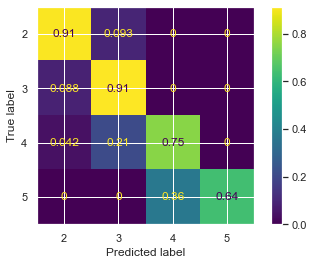

In [240]:
#Normalize the results by showing the percentage of predcited labels
test_confusion = metrics.confusion_matrix(y_test, y_pred_rfgs, normalize='true')
cmd = ConfusionMatrixDisplay(test_confusion, display_labels=[2,3,4,5])
cmd.plot()

The confusion matrix above, indicate that there is a good predcition rate on Rating 2 and 3, while 4 and 5 have less accuracy.

The model is not performing very well in differentiate the 4 and 5. Some of the Rating 5 reviews were predicted as 4. 

Also, the model is not perferming very well in differentiate 3 and 4, either. Some of the Rating 4 reviews were predicted as 3 or 2.

In [241]:
print(metrics.classification_report(y_test, y_pred_rfgs))

              precision    recall  f1-score   support

           2       0.94      0.91      0.92       257
           3       0.84      0.91      0.88       170
           4       0.82      0.75      0.78        24
           5       1.00      0.64      0.78        11

    accuracy                           0.89       462
   macro avg       0.90      0.80      0.84       462
weighted avg       0.90      0.89      0.89       462



The recall value for Rating 5 is low, indicating that the model is not very good in performing predcitions for 5, however, the precision number is high, indicating that if the model differentiate the review is rating 5, then it can reach 100% precision. 

This is the best model we can get for now. So we will use this model to do the following modeling analysis

# 6.0 Modelling <a id="6.0_Modelling"></a>

In [244]:
#We want to refit the model using all available data. 
#Do the same to the X_test sets
pre = preprocessor.fit(X)

In [246]:
X_cut = pre.transform(X)
X_cut = pd.DataFrame.sparse.from_spmatrix(X_cut)

In [247]:
labels = pre.get_feature_names_out()

In [252]:
rf_best.fit(X_cut, y)

RandomForestClassifier(max_depth=50, min_samples_split=4)

In [253]:
transformed_df_columns = pd.DataFrame(pre.transform(X).toarray(), columns=labels).columns
#Get the feature importance of each feature
feature_scores = pd.DataFrame(rf_best.feature_importances_, index=labels, columns=['Feature_Importance'])

feature_scores

,Feature_Importance
cat__Discipline_AC,4.266931e-03
cat__Discipline_BM,4.715498e-03
cat__Discipline_ES,5.882991e-03
cat__Discipline_HSS,1.178051e-03
cat__Discipline_PM,6.108795e-03
...,...
text__workingatmospheric,4.892275e-07
text__wrap,8.293105e-06
text__wrong,2.017710e-07
text__year,4.186190e-04


In [254]:
print(feature_scores.describe())
a = feature_scores.describe().iloc[6,0]

       Feature_Importance
count         1219.000000
mean             0.000820
std              0.007182
min              0.000000
25%              0.000015
50%              0.000087
75%              0.000331
max              0.177952


In [255]:
half_features = list(feature_scores[feature_scores['Feature_Importance']<=a].index)

In [257]:
X_cut.columns = labels
X_cut_df = X_cut.drop(columns = half_features)
X_cut_df.head()

,cat__Discipline_AC,cat__Discipline_BM,cat__Discipline_ES,cat__Discipline_HSS,cat__Discipline_PM,cat__Discipline_SC,cat__Discipline_SIC,cat__Discipline_SW,text__10,text__158,...,text__washdown,text__washwater,text__water,text__wear,text__weather,text__weathering,text__weatherstripping,text__wet,text__year,text__zone
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [258]:
rf_best.fit(X_cut_df, y)
y_pred = rf_best.predict(X_cut_df)
print("The accuracy for whole dataset is ", metrics.accuracy_score(y, y_pred))

The accuracy for whole dataset is  0.9722943722943723


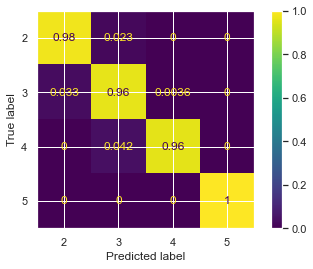

In [259]:
#Normalize the results by showing the percentage of predcited labels
test_confusion = metrics.confusion_matrix(y, y_pred, normalize='true')
cmd = ConfusionMatrixDisplay(test_confusion, display_labels=[2,3,4,5])
cmd.plot()

In [260]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           2       0.98      0.98      0.98      1332
           3       0.96      0.96      0.96       827
           4       0.97      0.96      0.96        96
           5       1.00      1.00      1.00        55

    accuracy                           0.97      2310
   macro avg       0.98      0.97      0.98      2310
weighted avg       0.97      0.97      0.97      2310



Assume that we recevied a new comment as below:


Descipline is PM

The comment is "this asset was observed in fair condition minor cracks and exposed aggregate and surface wear off were observed"

The rating of this asset is 3.

In [274]:
X_new = pd.DataFrame({'Discipline':['PM'], 
                      'lemmatized': ['minor cracks and exposed aggregate and surface wear off were observed'] })

X_new

,Discipline,lemmatized
0,PM,minor cracks and exposed aggregate and surface...


In [275]:
X_new = pre.transform(X_new)
X_new = pd.DataFrame.sparse.from_spmatrix(X_new)
X_new.columns = labels
X_new = X_new.drop(columns = half_features)
X_new.head()

,cat__Discipline_AC,cat__Discipline_BM,cat__Discipline_ES,cat__Discipline_HSS,cat__Discipline_PM,cat__Discipline_SC,cat__Discipline_SIC,cat__Discipline_SW,text__10,text__158,...,text__washdown,text__washwater,text__water,text__wear,text__weather,text__weathering,text__weatherstripping,text__wet,text__year,text__zone
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [276]:
rf_best.predict(X_new)

array([3])

The prediction is correct for this new review.